In [1]:
# Import necessary libraries for data visualization and analysis
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator, StrMethodFormatter)
import matplotlib as mpl

# Set the font family to 'Times New Roman' for consistent font usage
plt.rcParams['font.family'] = 'Times New Roman'

# Set the font size for the entire plot
mpl.rcParams['font.size'] = 45

In [2]:
# Load the L&B Events data

# Set the file path
file_path = r'C:\Users\labo\OneDrive - Nexus365\dissertation\LB_events_all_cleaned.csv'

# Load the dataset
dtype_dict = {"receive_receipt_token": "object"}
df = pd.read_csv(file_path, dtype=dtype_dict)
df.shape

(2977773, 35)

In [3]:
# Convert date and time columns to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time']).dt.time

In [6]:
# Filter the DataFrame to include rows with 'protocol' equal to 'compound/v2' and 'type' either 'withdraw' or 'deposit'
df = df[(df['protocol'] == 'compound/v2') & (df['type'].isin(['withdraw', 'deposit']))]
df.shape

(1350791, 35)

##### Identify the most frequent assets for deposits or withdrawals

In [8]:
# Identify the most frequent assets for deposits or withdrawals
top_assets_count = df['asset_symbol'].value_counts().head(12)
top_assets_count

usdc     467238
eth      338360
dai      284128
usdt      70788
wbtc      55801
bat       46672
uni       28555
comp      27767
zrx       19125
link       5712
rep        2861
sushi      1864
Name: asset_symbol, dtype: int64

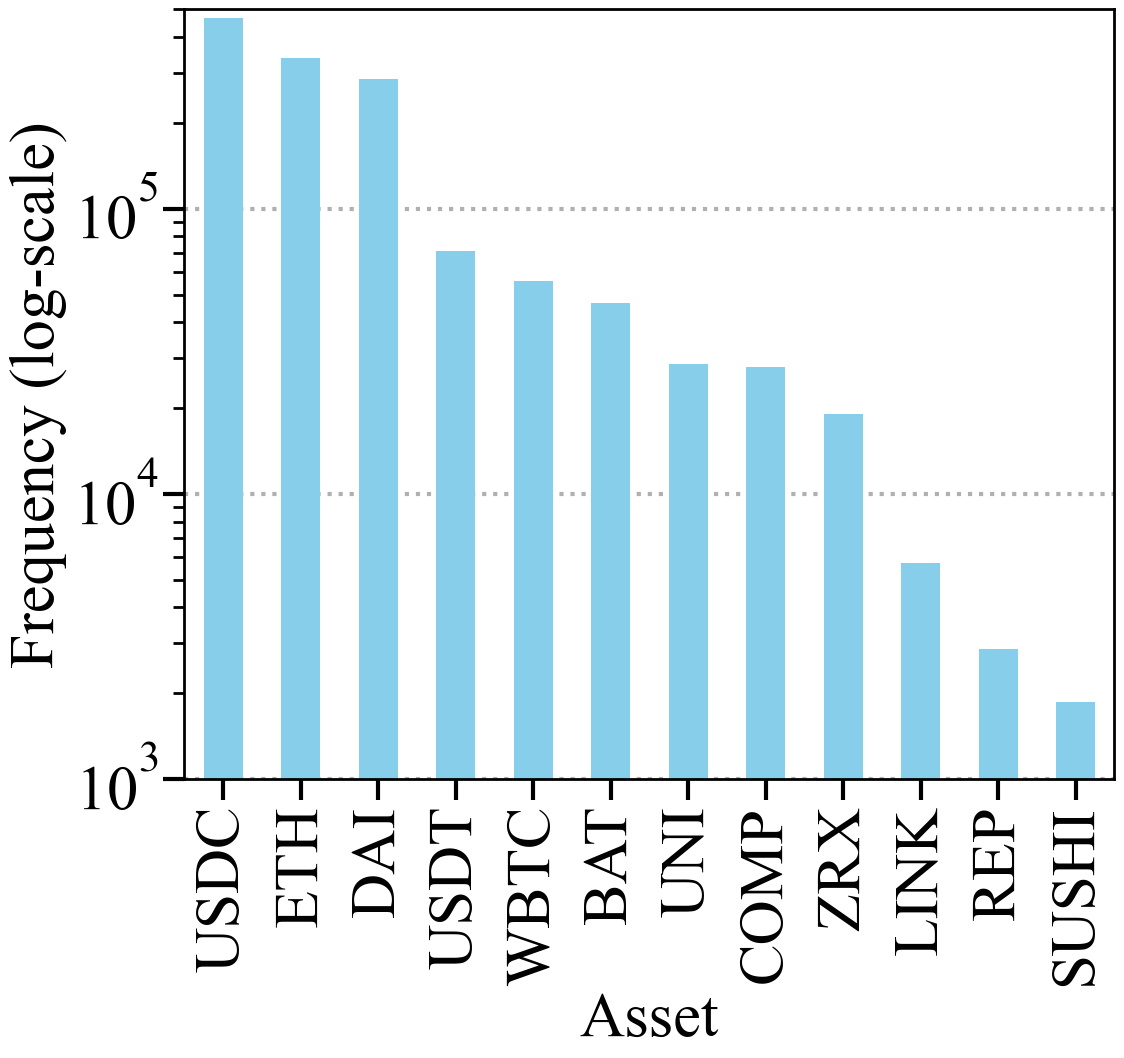

In [9]:
# Create a bar chart to visualize the top 12 assets with log-scale y-axis
plt.figure(figsize=(12, 10))
plt.gca().set_axisbelow(True)
plt.yscale('log')  # Set a logarithmic scale on the y-axis
top_assets_count.plot(kind='bar', color='skyblue')

# Set the labels and title
plt.xlabel('Asset')
plt.ylabel('Frequency (log-scale)')
plt.grid(axis='y', linestyle=':', linewidth=3)

# Extract only the first character for x-axis labels
plt.xticks(range(len(top_assets_count)), [label.upper() for label in top_assets_count.index], rotation=90)
plt.tick_params(axis='both', which='major', length=15, width=3)
plt.tick_params(axis='both', which='minor', length=8, width=2)

# Set y-axis limits
plt.ylim(10**3, (10**6)/2)

# Increase the width of the frame (border)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

# Show the plot
plt.show()

In [10]:
# Investigate if the top 9 tokens differ between deposits and withdrawals

# Get the top 9 tokens for deposits
deposits_tokens = df[df['type'] == 'deposit'].groupby('asset_symbol').size().sort_values(ascending=False).head(9).index.tolist()

# Get the top 9 tokens for withdrawals
withdrawals_tokens = df[df['type'] == 'withdraw'].groupby('asset_symbol').size().sort_values(ascending=False).head(9).index.tolist()

# Find the set symmetric difference (tokens that are unique to either deposits or withdrawals)
symmetric_difference = set(deposits_tokens) ^ set(withdrawals_tokens)

# Display the symmetric difference
symmetric_difference

set()

In [11]:
# Filter the DataFrame to include top 9 tokens overall
df = df[df['asset_symbol'].isin(deposits_tokens)]
df.shape

(1338434, 35)

##### Investigate the time period covered and define the observation period

In [12]:
# Investigate the time period covered and define the observation period

# Find the minimum date for each asset_symbol
min_dates = df.groupby('asset_symbol')['date'].min()

# Find the maximum date among the minimum dates
max_min_date = min_dates.max()

# Find the maximum date for each asset_symbol
max_dates = df.groupby('asset_symbol')['date'].max()

# Find the minimum date among the maximum dates
min_max_date = max_dates.min()

# Filter the DataFrame to include only rows within the defined observation period
df= df[(df['date'] >= max_min_date) &  (df['date'] <= min_max_date)]

# Print the shape of the filtered DataFrame
print("Shape of the DataFrame within the Observation Period:", df.shape)

Shape of the DataFrame within the Observation Period: (871382, 35)


##### Create a DataFrame for deposits only

In [13]:
# Create a DataFrame for deposits only

# Filter rows where 'type' is 'deposit'
deposits = df[df['type'] == 'deposit']

# Remove columns with all NaN values
deposits = deposits.dropna(axis=1, how='all')

deposits.shape

(591947, 27)

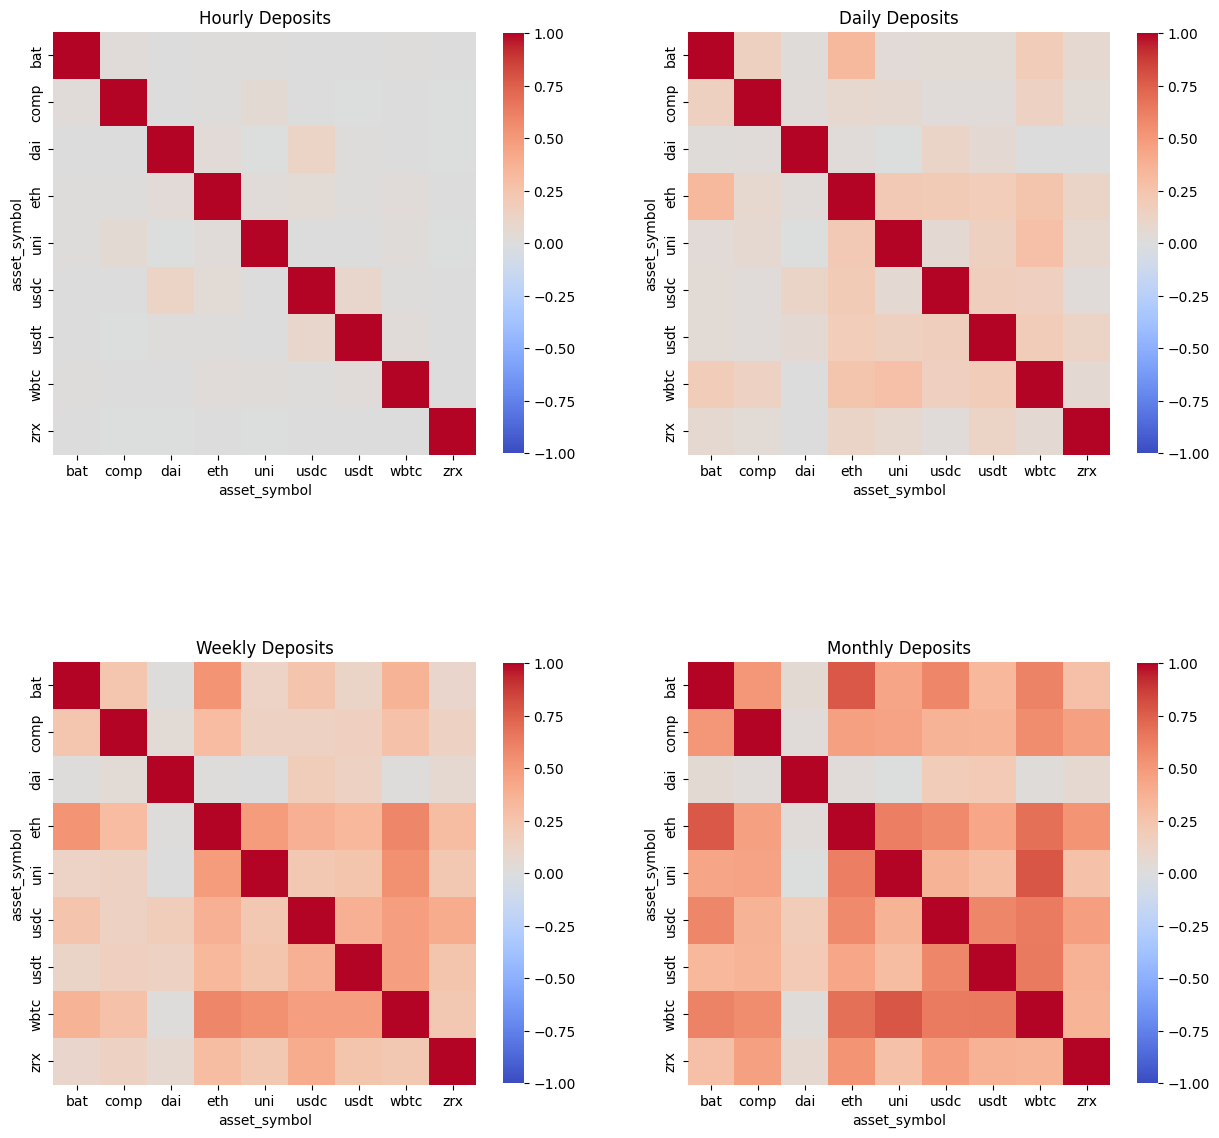

In [14]:
# Aggregating deposits at different time levels and visualizing correlations

# Reset font size to default
mpl.rcdefaults()

# Hourly Aggregation
deposits['hour_timestamp'] = deposits['datetime'].dt.floor('H')
deposits_hourly = deposits.groupby(['hour_timestamp', 'asset_symbol'])['amount'].sum().unstack().fillna(0)
corr_deposits_hourly = deposits_hourly.corr()

# Daily Aggregation
deposits_daily = deposits.groupby(['date', 'asset_symbol'])['amount'].sum().reset_index()
deposits_daily = deposits_daily.pivot(index='date', columns='asset_symbol', values='amount')
deposits_daily = deposits_daily.fillna(0)
corr_deposits_daily = deposits_daily.corr()

# Weekly Aggregation
deposits_weekly = deposits.groupby([pd.Grouper(key='date', freq='W'), 'asset_symbol'])['amount'].sum().reset_index()
deposits_weekly = deposits_weekly.pivot(index='date', columns='asset_symbol', values='amount')
deposits_weekly = deposits_weekly.fillna(0)
corr_deposits_weekly = deposits_weekly.corr()

# Monthly Aggregation
deposits['month'] = deposits['date'].dt.to_period('M')
deposits_monthly = deposits.groupby(['month', 'asset_symbol'])['amount'].sum().unstack().fillna(0)
corr_deposits_monthly = deposits_monthly.corr()

# Visualize the correlation matrices

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# List of correlation matrices and titles
corr_matrices_deposits = [corr_deposits_hourly, corr_deposits_daily, corr_deposits_weekly, corr_deposits_monthly]
titles = ['Hourly Deposits', 'Daily Deposits', 'Weekly Deposits', 'Monthly Deposits']

# Iterate through the subplots and plot each heatmap
for i, ax in enumerate(axes.flat):
    heatmap = sns.heatmap(corr_matrices_deposits[i], annot=False, fmt=".1f", square=True, ax=ax, vmin=-1, vmax=1, cmap='coolwarm', cbar_kws={"shrink": 0.8})
    ax.set_title(titles[i])

# Show the plot
plt.show()


##### Create a DataFrame for withdrawals only

In [15]:
# Create a DataFrame for withdrawals only

# Filter rows where 'type' is 'withdraw'
withdrawals = df[df['type'] == 'withdraw']

# Drop NaN columns except for 'rate'
columns_to_keep = withdrawals.columns[withdrawals.notna().any()].tolist()
columns_to_keep.append('rate')
withdrawals = withdrawals[columns_to_keep]
withdrawals.shape

(279435, 27)

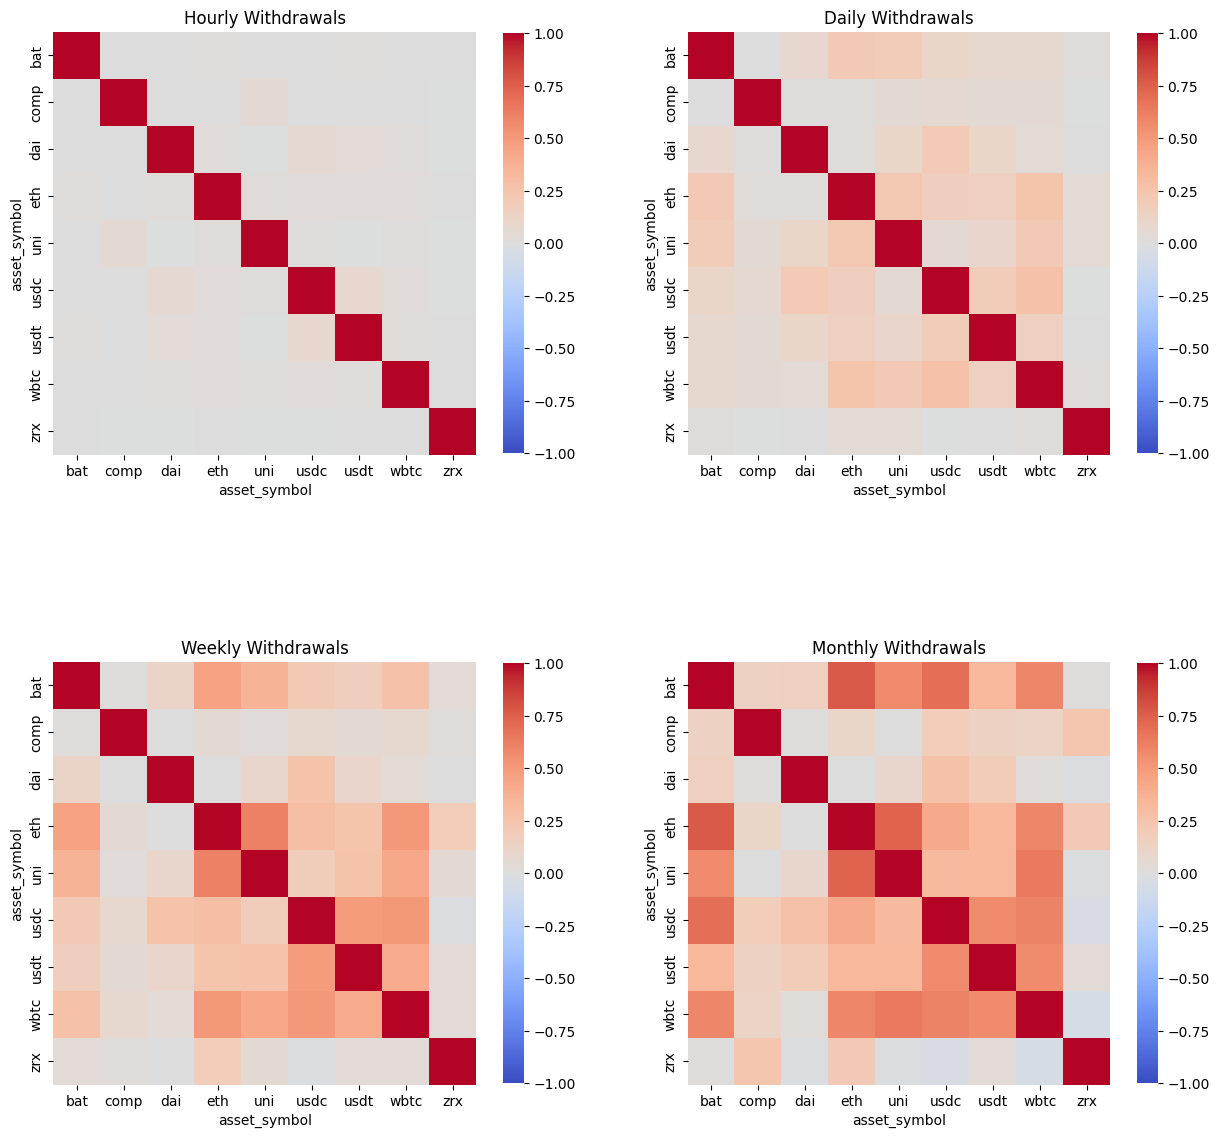

In [16]:
# Aggregating withdrawals at different time levels and visualizing correlations

# Hourly Aggregation
withdrawals['hour_timestamp'] = withdrawals['datetime'].dt.floor('H')
withdrawals_hourly = withdrawals.groupby(['hour_timestamp', 'asset_symbol'])['amount'].sum().unstack().fillna(0)
corr_withdrawals_hourly = withdrawals_hourly.corr()

# Daily Aggregation
withdrawals_daily = withdrawals.groupby(['date', 'asset_symbol'])['amount'].sum().reset_index()
withdrawals_daily = withdrawals_daily.pivot(index='date', columns='asset_symbol', values='amount')
withdrawals_daily = withdrawals_daily.fillna(0)
corr_withdrawals_daily = withdrawals_daily.corr()

# Weekly Aggregation
withdrawals_weekly = withdrawals.groupby([pd.Grouper(key='date', freq='W'), 'asset_symbol'])['amount'].sum().reset_index()
withdrawals_weekly = withdrawals_weekly.pivot(index='date', columns='asset_symbol', values='amount')
withdrawals_weekly = withdrawals_weekly.fillna(0)
corr_withdrawals_weekly = withdrawals_weekly.corr()

# Monthly Aggregation
withdrawals['month'] = withdrawals['date'].dt.to_period('M')
withdrawals_monthly = withdrawals.groupby(['month', 'asset_symbol'])['amount'].sum().unstack().fillna(0)
corr_withdrawals_monthly = withdrawals_monthly.corr()

# Visualize the correlation matrices

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# List of correlation matrices and titles
corr_matrices_withdrawals = [corr_withdrawals_hourly, corr_withdrawals_daily, corr_withdrawals_weekly, corr_withdrawals_monthly]
titles = ['Hourly Withdrawals', 'Daily Withdrawals', 'Weekly Withdrawals', 'Monthly Withdrawals']

# Iterate through the subplots and plot each heatmap
for i, ax in enumerate(axes.flat):
    heatmap = sns.heatmap(corr_matrices_withdrawals[i], annot=False, fmt=".1f", square=True, ax=ax, vmin=-1, vmax=1, cmap='coolwarm', cbar_kws={"shrink": 0.8})
    ax.set_title(titles[i])

# Show the plot
plt.show()

##### Create a DataFrame for net liquidity only

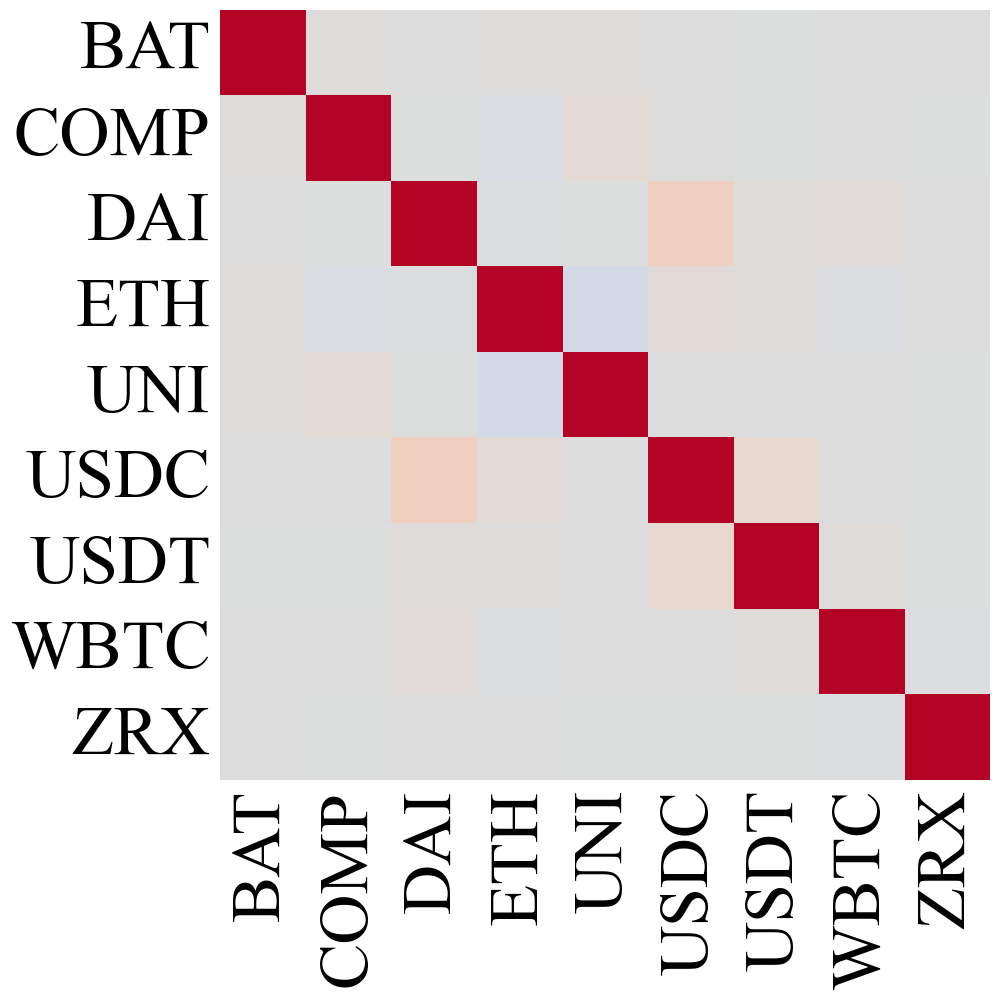

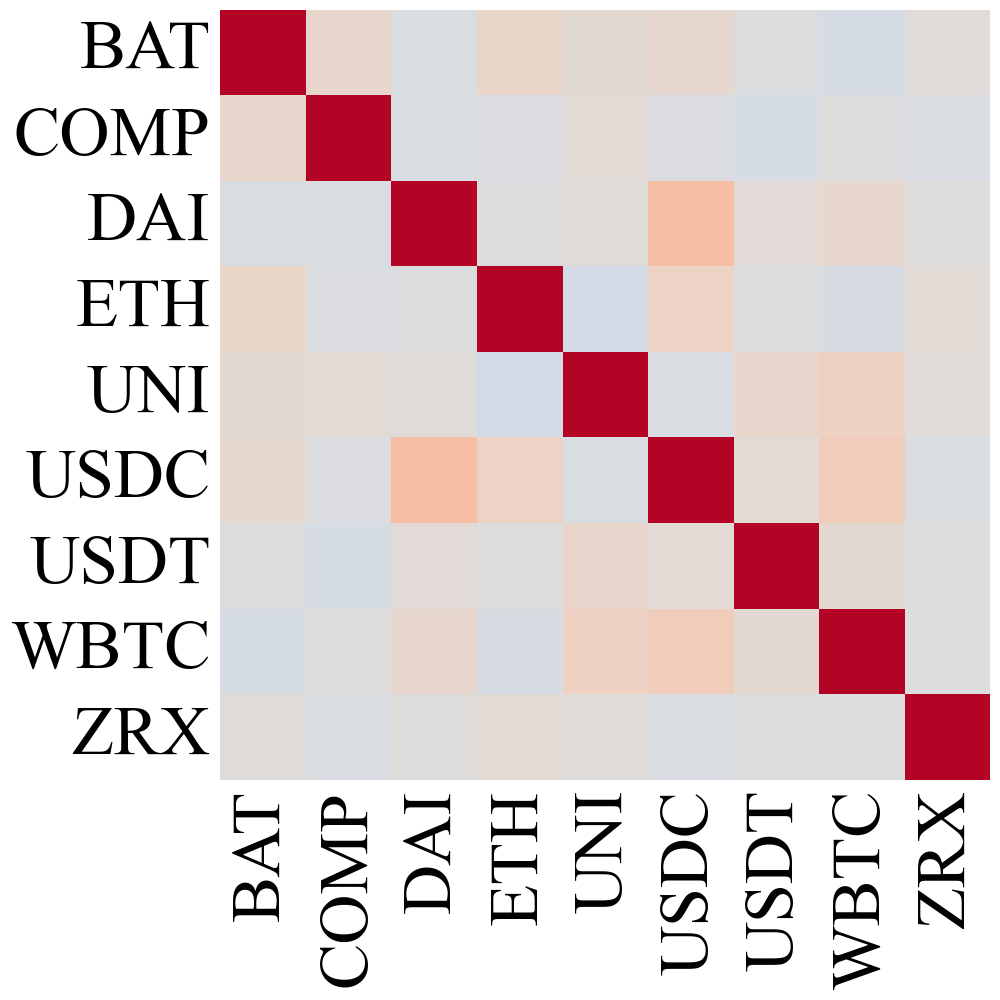

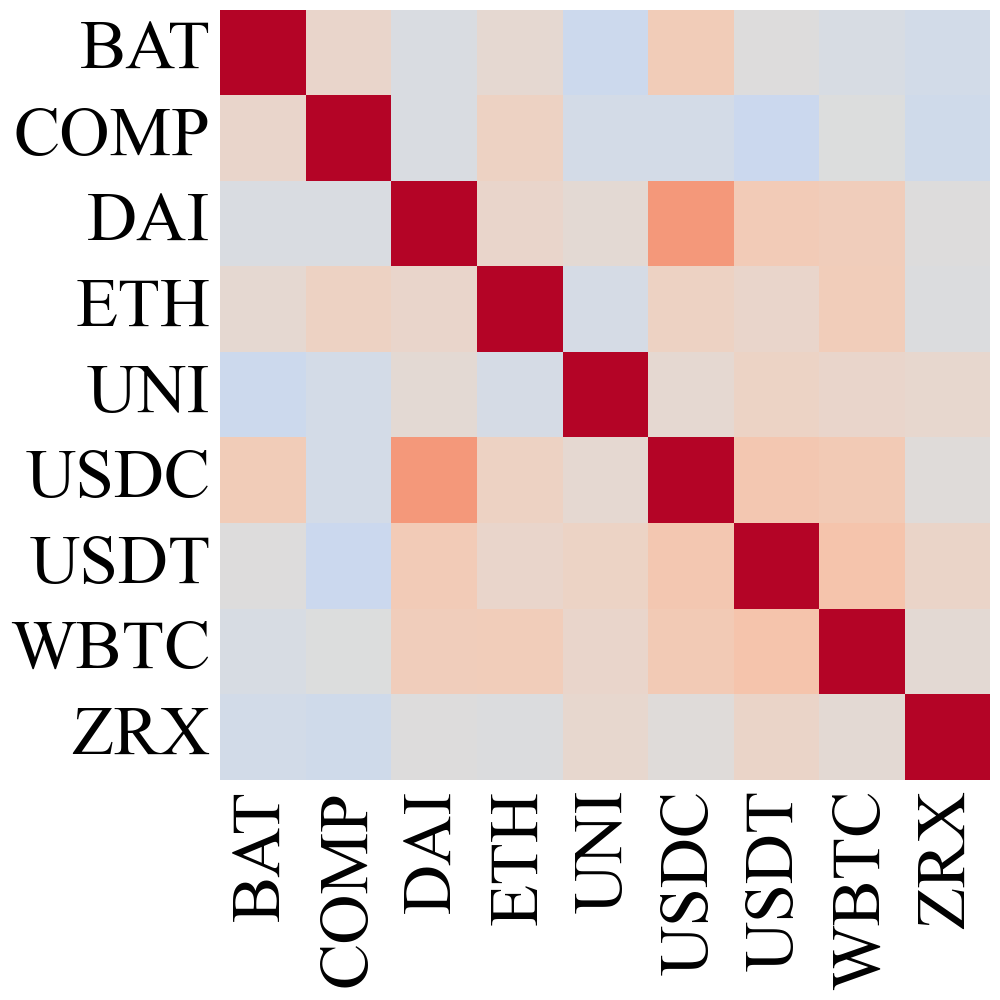

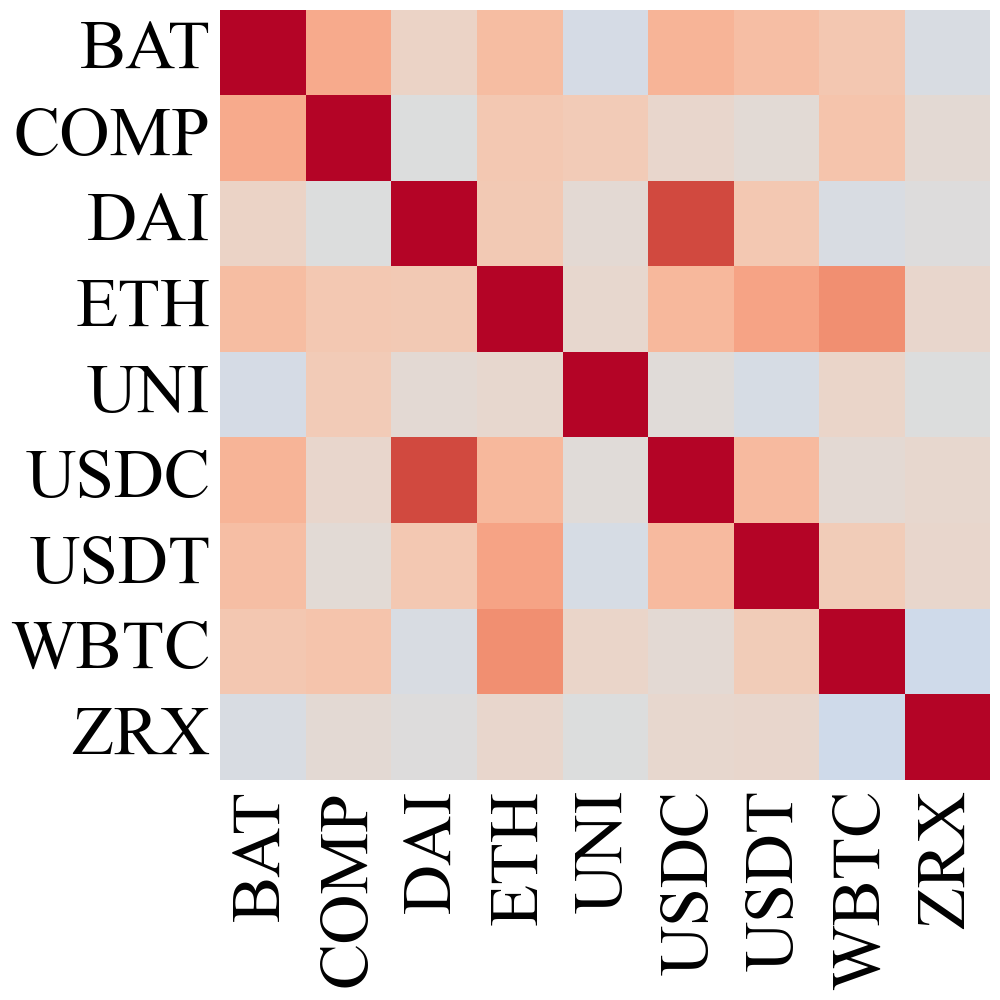

In [25]:
# Aggregating net liquidity flow (=deposits-withdrawals) at different time levels and visualizing correlations

# Hourly Aggregation
net_flow_hourly = deposits_hourly.sub(withdrawals_hourly, fill_value=0)
corr_net_flow_hourly = net_flow_hourly.corr()

# Daily Aggregation
net_flow_daily = deposits_daily.sub(withdrawals_daily, fill_value=0)
corr_net_flow_daily = net_flow_daily.corr()

# Weekly Aggregation
net_flow_weekly = deposits_weekly.sub(withdrawals_weekly, fill_value=0)
corr_net_flow_weekly = net_flow_weekly.corr()

# Monthly Aggregation
net_flow_monthly = deposits_monthly.sub(withdrawals_monthly, fill_value=0)
corr_net_flow_monthly = net_flow_monthly.corr()

# List of correlation matrices and titles
corr_matrices_net_flow = [corr_net_flow_hourly, corr_net_flow_daily, corr_net_flow_weekly, corr_net_flow_monthly]
titles = ['Hourly Net Flow', 'Daily Net Flow', 'Weekly Net Flow', 'Monthly Net Flow']

# Set font family to 'Times New Roman'
mpl.rc('font', family='Times New Roman')

# Iterate through the correlation matrices and save each heatmap separately
for i, corr_matrix in enumerate(corr_matrices_net_flow):
    # Create a new figure and axis for each heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corr_matrix, annot=False, fmt=".1f", square=True, vmin=-1, vmax=1, center=0, cmap='coolwarm', cbar_kws={"shrink": 0.95}, cbar=False)
    
    # Customize the title, labels, and tick labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.xaxis.set_tick_params(labelsize=50, labelrotation=90)
    ax.yaxis.set_tick_params(labelsize=50, labelrotation=0)
    ax.set_xticklabels([label.get_text().upper() for label in ax.get_xticklabels()])
    ax.set_yticklabels([label.get_text().upper() for label in ax.get_yticklabels()])
    ax.tick_params(bottom=False, left=False)

plt.show()